In [2]:
import requests as rq
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Copa Libertadores y Champions League
### Objetivo 
- Comparar estadísticamente ambas competiciones.
- Mostrar la evolución a través de los años 2014-2022 en ambas competencias.
- Mostar el desempeño de los equipos Chilenos en la Copa Libertadores

### Preguntas a responder
- ¿Que resultado es más común?¿Hay una gran diferencia dependiendo de la competicion?
- ¿Que resultado y diferencia de goles es el más comun por cada año?
- ¿Cual es la distribución de los goles por partido?
- ¿Cual es el promedio de goles y de diferencia de goles por año?
- ¿Cual fue el promedio de gol por pais y por equipo?
- ¿En cual competencia gana más el equipo local?
- Con respecto a la copa libertadores. ¿Contra que paises pierde con más frecuencia los partidos los equipos chilenos?
- ¿Cuál es el resultado típico con el cual los equipos chilenos pierde?
- ¿Cuales han sido las 5 peores derotas de los equipos Chilenos?

#### Para responder todas estas preguntas ocuaperamos los siguientes dataframes.

Primeros sacaremos la informacion de Copa libertadores  y Champions league. Ocuparemos webscrapping.

## Extraccion de informacion Copa Libertadores

In [3]:
LINK_LIB_GR = ["torneo=1048", "torneo=1047", "torneo=1046", "torneo=1045", 
                "torneo=1044", "torneo=1043", "torneo=1074", "torneo=1089"]

LINK_LIB_IDA_VUELTA = ["torneo=1048", "torneo=1047", "torneo=1046", "torneo=1045", 
                        "torneo=1044"]

LINK_LIB_UNICA = ["torneo=1043", "torneo=1074", "torneo=1089", "libertadores"]

DICC_MES = {'Enero': '1', 'Febrero': '2', 'Marzo': '3', 'Abril': '4', 'Mayo': '5', 'Junio': '6', 'Julio': '7', 'Agosto': '8', 
            'Septiembre': '9', 'Octubre': '10', 'Noviembre': '11', 'Diciembre': '12'}

DICT_EQUIPOS = {}

LISTA_RONDAS = ["Final", "Final", "Semifinal", "Semifinal", "Cuartos", "Cuartos", "Octavos", "Octavos"]

def revisar_equipo(l, equipo):
    for i in l:
        eq = i.replace(",", "")
        eq = eq.replace(".", "")
        eq = eq.replace(" ", "")
        if eq[:3].upper() == equipo.upper():
            return i
    return "Dep.Cali"

def im_a_equipo(l):
    paises = []
    for i in l:
        im = i.find("img")
        im = im.get("src")
        im = im.split("/")[2].split(".")[0]
        paises.append(im)
    return paises

locales = []
visitas = []
gol_locales = []
gol_visitas = []
ganador = []
goles = []
resultados = []
dif_goles = []
dias = []
anos = []
fases = []

Una vez ya definida nuestras respectivas variables y funciones. Vamos a definir los partdios de grupo.

In [4]:
ano = 2014
for num in LINK_LIB_GR:
    url = f"https://www.promiedos.com.ar/{num}"
    r = rq.get(url)
    sopa = bs(r.content, "html.parser")
    lista_grupos = sopa.find_all('div', class_ = 'grupo')
    for data in lista_grupos:
        equipos = data.find('table', id='posiciones')
        equipos = equipos.find_all('td', align = 'left')
        imagen = im_a_equipo(equipos)
        equipos = [i.text.replace(" ", "") for i in equipos]
        partidos = data.find_all('div', id = 'fixgrupo')

        for i in range(4):
            DICT_EQUIPOS[equipos[i]] = imagen[i]

        for datos in partidos:
            horario = datos.find_all('div', class_ = 'diahoragr')
            res = datos.find_all('div', class_ = 'grtr')

            for j in range(2):
                eq1 = res[j].find('div', class_ = 'greq1')
                eq1 = revisar_equipo(equipos, eq1.text)
                locales.append(eq1)
                eq2 = res[j].find('div', class_ = 'greq2')
                eq2 = revisar_equipo(equipos, eq2.text)
                visitas.append(eq2)

                resultado = res[j].find('div', class_ = 'grres4')
                resultado = resultado.text
                resultado = resultado.split('-')
                res1 = int(resultado[0])
                res2 = int(resultado[1])
                gol_locales.append(res1)
                gol_visitas.append(res2)
                resultados.append(str(res1) + "-" + str(res2))

                if res1 == res2:
                    ganador.append("Empate")
                    dif_goles.append(0)

                elif int(res1) > int(res2):
                    ganador.append("Local")
                    dif_goles.append(int(res1) - int(res2))

                elif int(res1) < int(res2):
                    ganador.append("Visita")
                    dif_goles.append(int(res2) - int(res1))

                goles.append(int(res1) + int(res2))
                anos.append(ano)
                dia = horario[j].text
                dia = dia.replace(",", "") ; dia = dia.split(" ")
                dia = dia[3]
                dias.append(dia)
                fases.append("Grupos")

    ano += 1


Añadimos las libertadores con final unica

In [5]:
for num in LINK_LIB_IDA_VUELTA:
    url = f"https://www.promiedos.com.ar/{num}"
    cont = 0
    r = rq.get(url)
    sopa = bs(r.content, "html.parser")
    lista_fases = sopa.find_all('div', id='partoff')
    for data in lista_fases:
        lista_partidos = data.find_all('div', id='fixturein')
        fase = LISTA_RONDAS[cont]
        for datos in lista_partidos:
            equ = datos.find_all('td', class_='game-t1')
            equ1 = equ[1].text ; equ2 = equ[2].text
            locales.append(equ1)
            visitas.append(equ2)

            res1 = datos.find_all('td', class_='game-r1')
            res1 = (res1[1].text)[0]
            gol_locales.append(int(res1))
            res2 = datos.find_all('td', class_='game-r2')
            res2 = (res2[1].text)[0]
            gol_visitas.append(int(res2))

            if int(res1) == int(res2):
                ganador.append("Empate")
                dif_goles.append(0)

            elif int(res1) > int(res2):
                ganador.append("Local")
                dif_goles.append(int(res1) - int(res2))

            elif int(res1) < int(res2):
                ganador.append("Visita")
                dif_goles.append(int(res2) - int(res1))

            goles.append(int(res1) + int(res2))
            resultados.append(res1 + "-" + res2)


            dia = datos.find_all('tr', class_='diapart')
            dia = dia[0].text
            dia = dia.split(" ")
            anos.append(dia[4])
            ano = dia[4]
            dia = dia[1] + "/"  + DICC_MES[dia[3]]
            dias.append(dia)

            fases.append(fase)

        cont += 1

In [6]:
for num in LINK_LIB_UNICA:
    url = f"https://www.promiedos.com.ar/{num}"
    cont = 2
    r = rq.get(url)
    sopa = bs(r.content, "html.parser")
    lista_fases = sopa.find_all('div', id='partoff')
    for data in lista_fases:
        lista_partidos = data.find_all('div', id='fixturein')
        fase = LISTA_RONDAS[cont]
        for datos in lista_partidos:
            equ = datos.find_all('td', class_='game-t1')
            equ1 = equ[1].text ; equ2 = equ[2].text
            locales.append(equ1)
            visitas.append(equ2)

            res1 = datos.find_all('td', class_='game-r1')
            res1 = (res1[1].text)[0]
            gol_locales.append(int(res1))
            res2 = datos.find_all('td', class_='game-r2')
            res2 = (res2[1].text)[0]
            gol_visitas.append(int(res2))

            if int(res1) == int(res2):
                ganador.append("Empate")
                dif_goles.append(0)

            elif int(res1) > int(res2):
                ganador.append("Local")
                dif_goles.append(int(res1) - int(res2))

            elif int(res1) < int(res2):
                ganador.append("Visita")
                dif_goles.append(int(res2) - int(res1))

            goles.append(int(res1) + int(res2))
            resultados.append(res1 + "-" + res2)


            dia = datos.find_all('tr', class_='diapart')
            dia = dia[0].text
            dia = dia.split(" ")
            if len(dia) < 5:
                anos.append("2022")
            else:
                anos.append(dia[4])
            dia = dia[1] + "/"  + DICC_MES[dia[3]]
            dias.append(dia)

            fases.append(fase)

        cont += 1
        if cont == 8:
            break

In [7]:
url = "https://www.promiedos.com.ar/libertadores=faseprevia"
page = rq.get(url)
page = bs(page.content, 'html.parser')
tabla = page.find('div', id='tablapts')
tabla = tabla.find_all('div', class_='grupo')
cont = 1
for data in tabla:
    l_equipos = []
    equipo = data.find('table', class_=f'tablesorter{cont}')
    equipo = equipo.find_all('tr')
    equipo.pop(0)
    imgs = im_a_equipo(equipo)
    for nom in equipo:
        nom = nom.find('td', align='left')
        l_equipos.append(nom.text.replace(' ', ''))
    for i in range(4):
        DICT_EQUIPOS[l_equipos[i]] = imgs[i]
    partidos = data.find_all('div', id = 'fixgrupo')
    cont += 1
    for datos in partidos:
        horario = datos.find_all('div', class_ = 'diahoragr')
        res = datos.find_all('div', class_ = 'grtr')

        for j in range(2):
            eq1 = res[j].find('div', class_ = 'greq1')
            eq1 = revisar_equipo(l_equipos, eq1.text)
            locales.append(eq1)
            eq2 = res[j].find('div', class_ = 'greq2')
            eq2 = revisar_equipo(l_equipos, eq2.text)
            visitas.append(eq2)

            resultado = res[j].find('div', class_ = 'grres4')
            resultado = resultado.text
            resultado = resultado.split('-')
            res1 = int(resultado[0])
            res2 = int(resultado[1])
            gol_locales.append(res1)
            gol_visitas.append(res2)
            resultados.append(str(res1) + "-" + str(res2))

            if res1 == res2:
                ganador.append("Empate")
                dif_goles.append(0)

            elif int(res1) > int(res2):
                ganador.append("Local")
                dif_goles.append(int(res1) - int(res2))

            elif int(res1) < int(res2):
                ganador.append("Visita")
                dif_goles.append(int(res2) - int(res1))

            goles.append(int(res1) + int(res2))
            anos.append(ano)
            dia = horario[j].text
            dia = dia.replace(",", "") ; dia = dia.split(" ")
            dia = dia[3]
            dias.append(dia)
            fases.append("Grupos")


In [8]:
locales = [i.replace(" ", "") for i in locales]
visitas = [i.replace(" ", "") for i in visitas]

In [9]:
paises_local = [DICT_EQUIPOS[i] for i in locales]
paises_visitas = [DICT_EQUIPOS[i] for i in visitas]

In [10]:
df_libertadores = pd.DataFrame()
df_libertadores["Local"] = locales
df_libertadores["Pais_local"] = paises_local
df_libertadores["Visita"] = visitas
df_libertadores["Pais_visita"] = paises_visitas
df_libertadores["Gol_local"] = gol_locales
df_libertadores["Gol_visita"] = gol_visitas
df_libertadores["Ganador"] = ganador
df_libertadores["Resultado"] = resultados
df_libertadores["Año"] = anos
df_libertadores["Fase"] = fases
df_libertadores["Goles"] = goles
df_libertadores["Diferencia_goles"] = dif_goles
df_libertadores["Dia"] = dias
df_libertadores

,Local,Pais_local,Visita,Pais_visita,Gol_local,Gol_visita,Ganador,Resultado,Año,Fase,Goles,Diferencia_goles,Dia
0,Universitario(P),peru,Velez,argentina,0,1,Visita,0-1,2014,Grupos,1,1,11/2
1,Paranaense,brasil,TheStrongest,bolivia,1,0,Local,1-0,2014,Grupos,1,1,13/2
2,TheStrongest,bolivia,Universitario(P),peru,1,0,Local,1-0,2014,Grupos,1,1,20/2
3,Velez,argentina,Paranaense,brasil,2,0,Local,2-0,2014,Grupos,2,2,25/2
4,TheStrongest,bolivia,Velez,argentina,2,0,Local,2-0,2014,Grupos,2,2,11/3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,Sp.Cristal,peru,U.Catolica,chile,1,1,Empate,1-1,2018,Grupos,2,0,4/5
1108,Flamengo,brasil,U.Catolica,chile,3,0,Local,3-0,2018,Grupos,3,3,17/5
1109,Sp.Cristal,peru,Talleres(C),argentina,0,0,Empate,0-0,2018,Grupos,0,0,17/5
1110,Flamengo,brasil,Sp.Cristal,peru,2,1,Local,2-1,2018,Grupos,3,1,24/5


## Extraccion de informacion Champions League

In [11]:
LINK_GRUP_CHMPS = ["torneo=1068", "torneo=1067", "torneo=1066", "torneo=1065", "torneo=1073", "torneo=1086", 
                    "torneo=1104", "championsleague"]
LINK_CHMPS =    ["torneo=1068", "torneo=1067", "torneo=1066", "torneo=1065", "torneo=1073",  "torneo=1086", 
                    "torneo=1104"]

DICC_MES = {'Enero': '1', 'Febrero': '2', 'Marzo': '3', 'Abril': '4', 'Mayo': '5', 'Junio': '6', 'Julio': '7', 'Agosto': '8', 
            'Septiembre': '9', 'Octubre': '10', 'Noviembre': '11', 'Diciembre': '12'}
            
#DICT_EQUIPOS = {}

LISTA_RONDAS = ["Final", "Final", "Semifinal", "Semifinal", "Cuartos", "Cuartos", "Octavos", "Octavos"]

def revisar_equipo(l, equipo):
    for i in l:
        eq = i.replace(",", "")
        eq = eq.replace(".", "")
        eq = eq.replace(" ", "")
        if eq[:3].upper() == equipo.upper():
            return i

def im_a_equipo(l):
    paises = []
    for i in l:
        im = i.find("img")
        im = im.get("src")
        im = im.split("/")[2].split(".")
        if im[1] == "png":
            im = "test"
        else:
            im = im[0]
            
        paises.append(im)
    return paises

locales = []
visitas = []
gol_locales = []
gol_visitas = []
ganador = []
goles = []
resultados = []
dif_goles = []
dias = []
anos = []
fases = []

In [12]:
ano = 2015
for num in LINK_GRUP_CHMPS:
    url = f"https://www.promiedos.com.ar/{num}"
    r = rq.get(url)
    sopa = bs(r.content, "html.parser")
    lista_grupos = sopa.find_all('div', class_ = 'grupo')
    for data in lista_grupos:
        equipos = data.find('table', id='posiciones')
        equipos = equipos.find_all('td', align = 'left')
        imagen = im_a_equipo(equipos)
        equipos = [i.text.replace(" ", "") for i in equipos]
        partidos = data.find_all('div', id = 'fixgrupo')

        for i in range(4):
            DICT_EQUIPOS[equipos[i]] = imagen[i]

        for datos in partidos:
            horario = datos.find_all('div', class_ = 'diahoragr')
            res = datos.find_all('div', class_ = 'grtr')

            for j in range(2):
                eq1 = res[j].find('div', class_ = 'greq1')
                eq1 = revisar_equipo(equipos, eq1.text)
                locales.append(eq1)
                eq2 = res[j].find('div', class_ = 'greq2')
                eq2 = revisar_equipo(equipos, eq2.text)
                visitas.append(eq2)

                resultado = res[j].find('div', class_ = 'grres4')
                resultado = resultado.text
                resultado = resultado.split('-')
                res1 = int(resultado[0])
                res2 = int(resultado[1])
                gol_locales.append(res1)
                gol_visitas.append(res2)
                resultados.append(str(res1) + "-" + str(res2))

                if res1 == res2:
                    ganador.append("Empate")
                    dif_goles.append(0)

                elif int(res1) > int(res2):
                    ganador.append("Local")
                    dif_goles.append(int(res1) - int(res2))

                elif int(res1) < int(res2):
                    ganador.append("Visita")
                    dif_goles.append(int(res2) - int(res1))

                goles.append(int(res1) + int(res2))
                anos.append(ano)
                dia = horario[j].text
                dia = dia.replace(",", "") ; dia = dia.split(" ")
                dia = dia[3]
                dias.append(dia)
                fases.append("Grupos")

    ano += 1

Agregamos las fases finales

Excepto las fases finales de 2020, ya que estas tienen otro formato, del 2020 solo agregamos la final

In [13]:
for num in LINK_CHMPS:
    url = f"https://www.promiedos.com.ar/{num}"
    r = rq.get(url)
    sopa = bs(r.content, "html.parser")
    final_unica = sopa.find_all('div', id='partoff1')
    equ = final_unica[0].find_all('td', class_='game-t1')
    equ = final_unica[0].find_all('td', class_='game-t1')
    equ1 = equ[1].text.replace(' ', '') ; equ2 = equ[2].text.replace(' ', '')
    locales.append(equ1)
    visitas.append(equ2)
    res1 = final_unica[0].find_all('td', class_='game-r1')
    res1 = (res1[1].text)[0]
    gol_locales.append(int(res1))
    res2 = final_unica[0].find_all('td', class_='game-r2')
    res2 = (res2[1].text)[0]
    gol_visitas.append(int(res2))

    if int(res1) == int(res2):
        ganador.append("Empate")
        dif_goles.append(0)

    elif int(res1) > int(res2):
        ganador.append("Local")
        dif_goles.append(int(res1) - int(res2))

    elif int(res1) < int(res2):
        ganador.append("Visita")
        dif_goles.append(int(res2) - int(res1))

    goles.append(int(res1) + int(res2))
    resultados.append(res1 + "-" + res2)


    dia = final_unica[0].find_all('tr', class_='diapart')
    dia = dia[0].text
    dia = dia.split(" ")
    if len(dia) <= 4:
        dia.append("2022")
    anos.append(dia[4])
    ano = dia[4]
    dia = dia[1] + '/' + DICC_MES[dia[3]]
    dias.append(dia)
    fases.append("Final")

In [14]:
LINK_CHMPS.pop(4)
for num in LINK_CHMPS:
    url = f"https://www.promiedos.com.ar/{num}"
    cont = 2
    r = rq.get(url)
    sopa = bs(r.content, "html.parser")
    lista_fases = sopa.find_all('div', id='partoff')
    for data in lista_fases:
        lista_partidos = data.find_all('div', id='fixturein')
        fase = LISTA_RONDAS[cont]
        for datos in lista_partidos:
            equ = datos.find_all('td', class_='game-t1')
            equ1 = equ[1].text ; equ2 = equ[2].text
            locales.append(equ1)
            visitas.append(equ2)

            res1 = datos.find_all('td', class_='game-r1')
            res1 = (res1[1].text)[0]
            gol_locales.append(int(res1))
            res2 = datos.find_all('td', class_='game-r2')
            res2 = (res2[1].text)[0]
            gol_visitas.append(int(res2))

            if int(res1) == int(res2):
                ganador.append("Empate")
                dif_goles.append(0)

            elif int(res1) > int(res2):
                ganador.append("Local")
                dif_goles.append(int(res1) - int(res2))

            elif int(res1) < int(res2):
                ganador.append("Visita")
                dif_goles.append(int(res2) - int(res1))

            goles.append(int(res1) + int(res2))
            resultados.append(res1 + "-" + res2)


            dia = datos.find_all('tr', class_='diapart')
            dia = dia[0].text
            dia = dia.split(" ")
            if len(dia) < 5:
                anos.append("2022")
            else:
                anos.append(dia[4])
            dia = dia[1] + "/"  + DICC_MES[dia[3]]
            dias.append(dia)

            fases.append(fase)

        cont += 1
        if cont == 8:
            break

Ahora agregamos la del 2020

In [15]:
url = f"https://www.promiedos.com.ar/torneo=1073"
cont = 4
r = rq.get(url)
sopa = bs(r.content, "html.parser")
final_unica = sopa.find_all('div', id='partoff1')
final_unica.pop(0)
data = final_unica[0].find_all('div', id = 'fixturein')
for datos in data:
    equ = datos.find_all('td', class_='game-t1')
    equ1 = equ[1].text ; equ2 = equ[2].text
    locales.append(equ1)
    visitas.append(equ2)

    res1 = datos.find_all('td', class_='game-r1')
    res1 = (res1[1].text)[0]
    gol_locales.append(int(res1))
    res2 = datos.find_all('td', class_='game-r2')
    res2 = (res2[1].text)[0]
    gol_visitas.append(int(res2))

    if int(res1) == int(res2):
        ganador.append("Empate")
        dif_goles.append(0)

    elif int(res1) > int(res2):
        ganador.append("Local")
        dif_goles.append(int(res1) - int(res2))

    elif int(res1) < int(res2):
        ganador.append("Visita")
        dif_goles.append(int(res2) - int(res1))

    goles.append(int(res1) + int(res2))
    resultados.append(res1 + "-" + res2)


    dia = datos.find_all('tr', class_='diapart')
    dia = dia[0].text
    dia = dia.split(" ")
    anos.append(dia[4])
    ano = dia[4]
    dia = dia[1] + "/"  + DICC_MES[dia[3]]
    dias.append(dia)
    fase = "Semifinal"
    fases.append(fase)

In [16]:
url = f"https://www.promiedos.com.ar/torneo=1073"
cont = 4
r = rq.get(url)
sopa = bs(r.content, "html.parser")
lista_fases = sopa.find_all('div', id='partoff')
for data in lista_fases:
    lista_partidos = data.find_all('div', id='fixturein')
    fase = LISTA_RONDAS[cont]
    for datos in lista_partidos:
        equ = datos.find_all('td', class_='game-t1')
        equ1 = equ[1].text ; equ2 = equ[2].text
        locales.append(equ1)
        visitas.append(equ2)

        res1 = datos.find_all('td', class_='game-r1')
        res1 = (res1[1].text)[0]
        gol_locales.append(int(res1))
        res2 = datos.find_all('td', class_='game-r2')
        res2 = (res2[1].text)[0]
        gol_visitas.append(int(res2))

        if int(res1) == int(res2):
            ganador.append("Empate")
            dif_goles.append(0)

        elif int(res1) > int(res2):
            ganador.append("Local")
            dif_goles.append(int(res1) - int(res2))

        elif int(res1) < int(res2):
            ganador.append("Visita")
            dif_goles.append(int(res2) - int(res1))

        goles.append(int(res1) + int(res2))
        resultados.append(res1 + "-" + res2)


        dia = datos.find_all('tr', class_='diapart')
        dia = dia[0].text
        dia = dia.split(" ")
        if len(dia) < 5:
            anos.append("2022")
        else:
            anos.append(dia[4])
        dia = dia[1] + "/"  + DICC_MES[dia[3]]
        dias.append(dia)

        fases.append(fase)

    cont += 1
    if cont == 8:
        break

In [17]:
locales = [i.replace(" ", "") for i in locales]
visitas = [i.replace(" ", "") for i in visitas]

In [18]:
DICT_EQUIPOS["D.Zagreb"] = "croacia" ; DICT_EQUIPOS["Maccabi"] = "israel" ; DICT_EQUIPOS["Gent"] = "belgica"
DICT_EQUIPOS["Rostov"] = "rusia" ; DICT_EQUIPOS["CSKA"] = "rusia" ; DICT_EQUIPOS["Maribor"] = "estonia"

In [19]:
paises_local = [DICT_EQUIPOS[i] for i in locales]
paises_visitas = [DICT_EQUIPOS[i] for i in visitas]

In [20]:
df_champions = pd.DataFrame()
df_champions["Local"] = locales
df_champions["Pais_local"] = paises_local
df_champions["Visita"] = visitas
df_champions["Pais_visita"] = paises_visitas
df_champions["Gol_local"] = gol_locales
df_champions["Gol_visita"] = gol_visitas
df_champions["Ganador"] = ganador
df_champions["Resultado"] = resultados
df_champions["Año"] = anos
df_champions["Fase"] = fases
df_champions["Goles"] = goles
df_champions["Diferencia_goles"] = dif_goles
df_champions["Dia"] = dias
df_champions

,Local,Pais_local,Visita,Pais_visita,Gol_local,Gol_visita,Ganador,Resultado,Año,Fase,Goles,Diferencia_goles,Dia
0,PSG,francia,Malmo,suecia,2,0,Local,2-0,2015,Grupos,2,2,15/9
1,RealMadrid,espana,Shakhtar,ucrania,4,0,Local,4-0,2015,Grupos,4,4,15/9
2,Malmo,suecia,RealMadrid,espana,0,2,Visita,0-2,2015,Grupos,2,2,30/9
3,Shakhtar,ucrania,PSG,francia,0,3,Visita,0-3,2015,Grupos,3,3,30/9
4,Malmo,suecia,Shakhtar,ucrania,1,0,Local,1-0,2015,Grupos,1,1,21/10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,Juventus,italia,Lyon,francia,2,1,Local,2-1,2020,Octavos,3,1,07/8
961,Tottenham,inglaterra,RBLeipzig,alemania,0,1,Visita,0-1,2020,Octavos,1,1,19/2
962,RBLeipzig,alemania,Tottenham,inglaterra,3,0,Local,3-0,2020,Octavos,3,3,10/3
963,Napoli,italia,Barcelona,espana,1,1,Empate,1-1,2020,Octavos,2,0,25/2


In [21]:
df_champions["Año"] = df_champions["Año"].astype("str");
df_libertadores["Año"] = df_libertadores["Año"].astype("str");

In [22]:
df_champions["Competicion"] = "champions"
df_libertadores["Competicion"] = "libertadores"
df_concat = pd.concat([df_champions, df_libertadores])
df_concat

,Local,Pais_local,Visita,Pais_visita,Gol_local,Gol_visita,Ganador,Resultado,Año,Fase,Goles,Diferencia_goles,Dia,Competicion
0,PSG,francia,Malmo,suecia,2,0,Local,2-0,2015,Grupos,2,2,15/9,champions
1,RealMadrid,espana,Shakhtar,ucrania,4,0,Local,4-0,2015,Grupos,4,4,15/9,champions
2,Malmo,suecia,RealMadrid,espana,0,2,Visita,0-2,2015,Grupos,2,2,30/9,champions
3,Shakhtar,ucrania,PSG,francia,0,3,Visita,0-3,2015,Grupos,3,3,30/9,champions
4,Malmo,suecia,Shakhtar,ucrania,1,0,Local,1-0,2015,Grupos,1,1,21/10,champions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,Sp.Cristal,peru,U.Catolica,chile,1,1,Empate,1-1,2018,Grupos,2,0,4/5,libertadores
1108,Flamengo,brasil,U.Catolica,chile,3,0,Local,3-0,2018,Grupos,3,3,17/5,libertadores
1109,Sp.Cristal,peru,Talleres(C),argentina,0,0,Empate,0-0,2018,Grupos,0,0,17/5,libertadores
1110,Flamengo,brasil,Sp.Cristal,peru,2,1,Local,2-1,2018,Grupos,3,1,24/5,libertadores


¿Que resultado es más común?¿Hay una gran diferencia dependiendo de la competicion?

In [23]:
df_libertadores['Resultado'].value_counts().head()

1-0    129
1-1    128
2-0    110
0-0     93
0-1     91
Name: Resultado, dtype: int64

In [24]:
df_champions['Resultado'].value_counts().head()

1-1    89
2-0    79
2-1    76
1-2    76
1-0    69
Name: Resultado, dtype: int64

In [25]:
df_concat['Resultado'].value_counts().head()

1-1    217
1-0    198
2-0    189
2-1    166
0-0    151
Name: Resultado, dtype: int64

¿Que resultado y diferencia de goles es el más comun por cada año?

In [26]:
p2_lib = df_libertadores.groupby(by = "Año", as_index = False).agg({"Resultado":pd.Series.mode, "Diferencia_goles":pd.Series.mode})
p2_lib

,Año,Resultado,Diferencia_goles
0,2014,1-0,1
1,2015,2-0,1
2,2016,1-1,1
3,2017,"[1-0, 1-1]",1
4,2018,1-0,1
5,2019,2-0,1
6,2020,3-0,1
7,2021,0-0,1
8,2022,1-1,0


In [27]:
p2_champs = df_champions.groupby(by = "Año", as_index = False).agg({"Resultado":pd.Series.mode, "Diferencia_goles":pd.Series.mode})
p2_champs

,Año,Resultado,Diferencia_goles
0,2015,2-1,1
1,2016,1-0,1
2,2017,1-1,1
3,2018,1-2,1
4,2019,0-2,1
5,2020,1-1,1
6,2021,2-0,1
7,2022,1-1,2


In [28]:
p2_concat = df_concat.groupby(by = "Año", as_index = False).agg({"Resultado":pd.Series.mode, "Diferencia_goles":pd.Series.mode})
p2_concat

,Año,Resultado,Diferencia_goles
0,2014,1-0,1
1,2015,2-0,1
2,2016,1-1,1
3,2017,1-1,1
4,2018,1-0,1
5,2019,2-0,1
6,2020,"[1-1, 1-2, 3-0]",1
7,2021,2-0,1
8,2022,1-1,1


¿Cual es la densidad de los goles por partido?

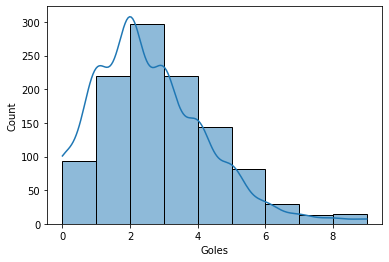

In [83]:
sns.histplot(data = df_libertadores, x = "Goles", kde = True, bins = 9);

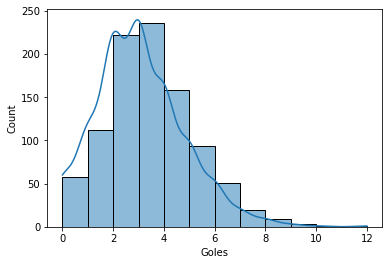

In [82]:
sns.histplot(data = df_champions, x = "Goles", kde = True, bins = 12);

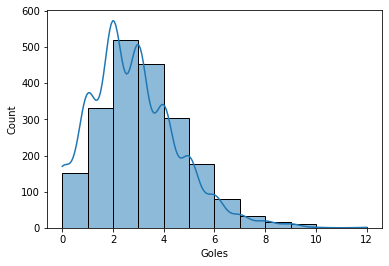

In [84]:
sns.histplot(data = df_concat, x = "Goles", kde = True, bins = 12);

¿Cual es el promedio de goles y de diferencia de goles por año?

In [29]:
df_concat.replace({"libertadores" : 0, "champions" : 1});

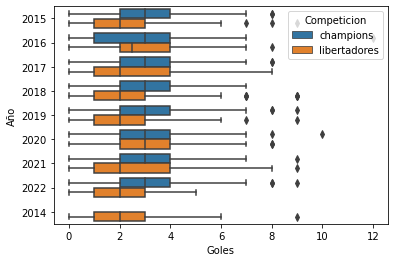

In [30]:
sns.boxplot(data = df_concat, x = "Goles", y = "Año", hue = "Competicion");

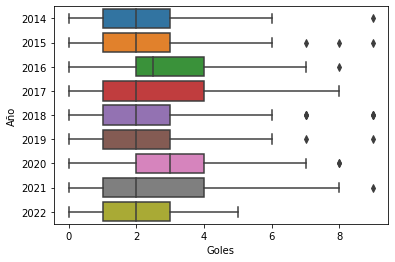

In [31]:
sns.boxplot(data = df_libertadores, x = "Goles", y = "Año");

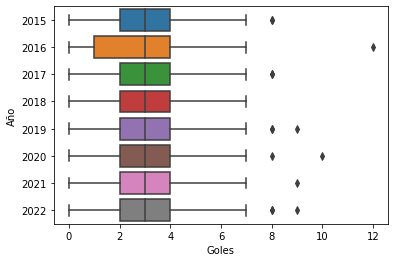

In [32]:
sns.boxplot(data = df_champions, x = "Goles", y = "Año");

Ahora con la diferencia de goles

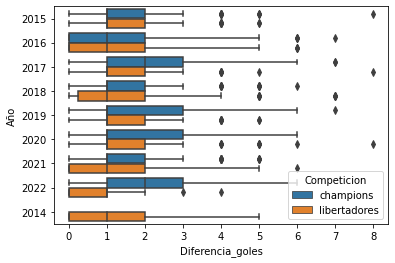

In [33]:
sns.boxplot(data = df_concat, x = "Diferencia_goles", y = "Año", hue = "Competicion");

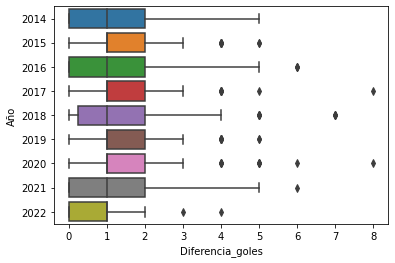

In [34]:
sns.boxplot(data = df_libertadores, x = "Diferencia_goles", y = "Año");

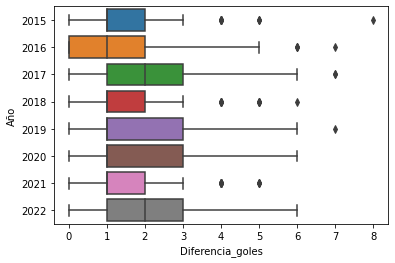

In [35]:
sns.boxplot(data = df_champions, x = "Diferencia_goles", y = "Año");

 ¿Cual fue el promedio de gol por pais?

In [36]:
df_por_pais1 = df_concat.groupby(by = "Pais_local", as_index = False).agg({"Gol_local":["sum", "count"]})
df_por_pais2 = df_concat.groupby(by = "Pais_visita", as_index = False).agg({"Gol_visita":["sum", "count"]})

In [37]:
pais = []
prom = []
for i in range(len(df_por_pais1["Pais_local"])):
    pais.append(df_por_pais1["Pais_local"][i])
    sum = (df_por_pais1["Gol_local"]["sum"][i] + df_por_pais2["Gol_visita"]["sum"][i])
    count = (df_por_pais1["Gol_local"]["count"][i] + df_por_pais2["Gol_visita"]["count"][i])
    prom.append(sum / count)
df_por_pais = pd.DataFrame()
df_por_pais["Pais"] = pais
df_por_pais["Promedio_gol"] = prom
df_por_pais = df_por_pais.sort_values("Promedio_gol", ascending = False)
df_por_pais = df_por_pais.reset_index(drop = True)
df_por_pais.head()

,Pais,Promedio_gol
0,inglaterra,1.946844
1,alemania,1.928287
2,mexico,1.750000
3,espana,1.675410
4,francia,1.611465


¿En cual competencia gana más el equipo local?

In [68]:
df_local_lib = df_libertadores[df_libertadores["Ganador"] == "Local"]
df_local_chmps = df_champions[df_champions["Ganador"] == "Local"]
df_local_chile = df_libertadores[df_libertadores["Pais_local"] == "chile"]
partidos_chile = len(df_local_chile["Ganador"])
df_local_chile = df_local_chile[df_local_chile["Ganador"] == "Local"]

In [71]:
porcentaje_lib = len(df_local_lib["Ganador"])*100 / len(df_libertadores["Ganador"])
porcentaje_chmps = len(df_local_chmps["Ganador"])*100 / len(df_champions["Ganador"])
porcentaje_chile = len(df_local_chile["Ganador"])*100 / partidos_chile
print(f"El porcentaje de victoria del local en la libertadores es {porcentaje_lib}, en cambio"
f" en la champions es de {porcentaje_chmps}, con esto vemos que en sudamerica importa más la localía\n")
print(f"Por ultimo vemos que el porcentaje de victoria cuando un equipo chileno es chileno, este logra la victoria"
f" en un {porcentaje_chile} porciento de las veces, esto es bajo del promedio de la competición")

El porcentaje de victoria del local en la libertadores es 50.6294964028777, en cambio en la champions es de 45.69948186528497, con esto vemos que en sudamerica importa más la localía

Por ultimo vemos que el porcentaje de victoria cuando un equipo chileno es chileno, este logra la victoria en un 39.0625 porciento de las veces, esto es bajo del promedio de la competición


### ¿Cuál es el promedio de goles por equipo?

In [40]:
lista_mejores = []
for ano in df_libertadores['Año'].unique():
    locales2 = df_libertadores[df_libertadores['Año'] == ano]
    locales2 = locales2[['Local', 'Gol_local']].groupby(by='Local', as_index=False).agg('mean')
    locales2.rename(columns={'Local': 'Equipo'}, inplace=True)
    visita2 = df_libertadores[df_libertadores['Año'] == ano]
    visita2 = visita2[['Visita', 'Gol_visita']].groupby(by='Visita', as_index=False).agg('mean')
    visita2.rename(columns={'Visita': 'Equipo'}, inplace=True)
    goles_prom = locales2.merge(visita2, how='inner', on='Equipo')
    goles_prom['Ano'] = ano
    goles_prom['Pais'] = goles_prom['Equipo'].apply(lambda x: DICT_EQUIPOS[x])
    goles_prom['Promedio_goles'] = (goles_prom['Gol_local'] + goles_prom['Gol_visita']) / 2
    goles_prom['Promedio_goles'] = goles_prom['Promedio_goles'].round()
    goles_prom['Promedio_goles'] = goles_prom['Promedio_goles'].apply(lambda x: int(x))
    goles_prom.drop(columns=['Gol_local', 'Gol_visita'], inplace=True)
    goles_prom.sort_values(by='Promedio_goles', ascending=False, ignore_index=True, inplace=True)
    goles_prom = goles_prom[:1]
    lista_mejores.append(goles_prom)

In [41]:
mejores_lib = pd.concat(lista_mejores, join='outer', ignore_index=True)
mejores_lib

,Equipo,Ano,Pais,Promedio_goles
0,LeonFC,2014,mexico,2
1,JuanAurich,2015,peru,2
2,Atl.Mineiro,2016,brasil,2
3,Atl.Mineiro,2017,brasil,2
4,Palmeiras,2018,brasil,3
5,LigaQuito,2019,ecuador,2
6,RiverPlate,2020,argentina,3
7,Flamengo,2021,brasil,3
8,Atl.Mineiro,2022,brasil,2


In [42]:
lista_mejores2 = []
for ano in df_champions['Año'].unique():
    locales3 = df_champions[df_champions['Año'] == ano]
    locales3 = locales3[['Local', 'Gol_local']].groupby(by='Local', as_index=False).agg('mean')
    locales3.rename(columns={'Local': 'Equipo'}, inplace=True)
    visita3 = df_champions[df_champions['Año'] == ano]
    visita3 = visita3[['Visita', 'Gol_visita']].groupby(by='Visita', as_index=False).agg('mean')
    visita3.rename(columns={'Visita': 'Equipo'}, inplace=True)
    goles_prom2 = locales3.merge(visita3, how='inner', on='Equipo')
    goles_prom2['Año'] = ano
    goles_prom2['Pais'] = goles_prom2['Equipo'].apply(lambda x: DICT_EQUIPOS[x])
    goles_prom2['Promedio_goles'] = (goles_prom2['Gol_local'] + goles_prom2['Gol_visita']) / 2
    goles_prom2['Promedio_goles'] = goles_prom2['Promedio_goles'].round()
    goles_prom2['Promedio_goles'] = goles_prom2['Promedio_goles'].apply(lambda x: int(x))
    goles_prom2.drop(columns=['Gol_local', 'Gol_visita'], inplace=True)
    goles_prom2.sort_values(by='Promedio_goles', ascending=False, ignore_index=True, inplace=True)
    goles_prom2 = goles_prom2[:1]
    lista_mejores2.append(goles_prom2)

In [43]:
mejores_cham = pd.concat(lista_mejores2, join='outer', ignore_index=True)
mejores_cham

,Equipo,Año,Pais,Promedio_goles
0,RealMadrid,2015,espana,3
1,B.Dortmund,2016,alemania,4
2,Liverpool,2017,inglaterra,4
3,PSG,2018,francia,2
4,Salzburgo,2019,austria,3
5,Monchengladbach,2020,alemania,3
6,Ajax,2021,paisesbajos,3
7,Napoli,2022,italia,3


In [44]:
prom_lib = mejores_lib[['Equipo', 'Pais']].groupby(by='Pais', as_index=False).agg('count')
prom_lib.sort_values(by='Equipo', ascending=False, ignore_index=True, inplace=True)
prom_lib

,Pais,Equipo
0,brasil,5
1,argentina,1
2,ecuador,1
3,mexico,1
4,peru,1


In [45]:
prom_cham = mejores_cham[['Equipo', 'Pais']].groupby(by='Pais', as_index=False).agg('count')
prom_cham.sort_values(by='Equipo', ascending=False, ignore_index=True, inplace=True)
prom_cham

,Pais,Equipo
0,alemania,2
1,austria,1
2,espana,1
3,francia,1
4,inglaterra,1
5,italia,1
6,paisesbajos,1


### ¿Es proporcional la cantidad de goles con las veces que el equipo gana?

In [46]:
ganadores_lib = df_libertadores[df_libertadores["Fase"] == "Final"]
ganadores_lib.reset_index(drop=True, inplace=True)
ganadores_cham = df_champions[df_champions["Fase"] == "Final"]
ganadores_cham.reset_index(drop=True, inplace=True)

In [47]:
list_ganadores= []
for equipo in mejores_lib['Equipo'].unique():
    info = ganadores_lib[ganadores_lib['Local'] == equipo]
    info2 = ganadores_lib[ganadores_lib['Visita'] == equipo]
    list_ganadores.append(info)
ganadores_lib2 = pd.concat(list_ganadores, ignore_index=True)
ganadores_lib2

,Local,Pais_local,Visita,Pais_visita,Gol_local,Gol_visita,Ganador,Resultado,Año,Fase,Goles,Diferencia_goles,Dia,Competicion
0,RiverPlate,argentina,TigresUANL,mexico,3,0,Local,3-0,2015,Final,3,3,05/8,libertadores
1,RiverPlate,argentina,BocaJuniors,argentina,3,1,Local,3-1,2018,Final,4,2,09/12,libertadores


In [48]:
list_ganadores2 = []
for equipo in mejores_cham['Equipo'].unique():
    info = ganadores_cham[ganadores_cham['Local'] == equipo]
    info2 = ganadores_cham[ganadores_cham['Visita'] == equipo]
    list_ganadores2.append(info)
ganadores_cham2 = pd.concat(list_ganadores2, ignore_index=True)
ganadores_cham2

,Local,Pais_local,Visita,Pais_visita,Gol_local,Gol_visita,Ganador,Resultado,Año,Fase,Goles,Diferencia_goles,Dia,Competicion
0,RealMadrid,espana,AtleticoMadrid,espana,1,1,Empate,1-1,2016,Final,2,0,28/5,champions
1,RealMadrid,espana,Liverpool,inglaterra,3,1,Local,3-1,2018,Final,4,2,26/5,champions
2,Liverpool,inglaterra,RealMadrid,espana,0,1,Visita,0-1,2022,Final,1,1,28/5,champions
3,PSG,francia,BayernMunich,alemania,0,1,Visita,0-1,2020,Final,1,1,23/8,champions


Notamos que no existe relación entre que si un país es goleador entonces será el ganador, ya que, en ambas competiciones no hay un año donde el equipo ganador sea el equipo goleador de ese año.

### Con respecto a la copa libertadores. ¿Contra que paises pierde con más frecuencia los partidos los equipos chilenos?

In [49]:
df_chile1 = df_libertadores[df_libertadores["Pais_local"] == "chile"]
df_chile2 = df_libertadores[df_libertadores["Pais_visita"] == "chile"]

In [50]:
df_chile1 = df_chile1[df_chile1["Ganador"] == "Visita"]
df_chile2 = df_chile2[df_chile2["Ganador"] == "Local"]
df_chile = pd.concat([df_chile1, df_chile2])
df_chile = df_chile.reset_index(drop = True)
df_chile

,Local,Pais_local,Visita,Pais_visita,Gol_local,Gol_visita,Ganador,Resultado,Año,Fase,Goles,Diferencia_goles,Dia,Competicion
0,UnionEspañola,chile,Ind.delValle,ecuador,4,5,Visita,4-5,2014,Grupos,9,1,9/4,libertadores
1,Univ.deChile,chile,Cruzeiro,brasil,0,2,Visita,0-2,2014,Grupos,2,2,3/4,libertadores
2,ColoColo,chile,Ind.SantaFe,colombia,0,3,Visita,0-3,2015,Grupos,3,3,15/4,libertadores
3,Univ.deChile,chile,Emelec,ecuador,0,1,Visita,0-1,2015,Grupos,1,1,17/2,libertadores
4,Univ.deChile,chile,Internacional,brasil,0,4,Visita,0-4,2015,Grupos,4,4,16/4,libertadores
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Corinthians,brasil,ColoColo,chile,2,1,Local,2-1,2018,Octavos,3,1,29/8,libertadores
60,Palmeiras,brasil,U.Catolica,chile,1,0,Local,1-0,2021,Octavos,1,1,21/7,libertadores
61,RiverPlate,argentina,ColoColo,chile,4,0,Local,4-0,2018,Grupos,4,4,19/5,libertadores
62,Talleres(C),argentina,U.Catolica,chile,1,0,Local,1-0,2018,Grupos,1,1,6/4,libertadores


In [51]:
df_chile1.reset_index(drop=True, inplace=True)
df_chile2.reset_index(drop=True, inplace=True)

In [52]:
perdedor = df_chile1[['Visita', 'Pais_visita']].groupby(by='Pais_visita', as_index=False).agg('count')
perdedor.sort_values(by='Visita', ascending=False, inplace=True)
perdedor.reset_index(drop=True, inplace=True)
perdedor.rename(columns={'Pais_visita': 'Pais'}, inplace=True)

In [53]:
perdedor2 = df_chile2[['Local', 'Pais_local']].groupby(by='Pais_local', as_index=False).agg('count')
perdedor2.sort_values(by='Local', ascending=False, inplace=True)
perdedor2.reset_index(drop=True, inplace=True)
perdedor2.rename(columns={'Pais_local': 'Pais'}, inplace=True)

In [54]:
chile_perdedor = perdedor.merge(perdedor2, how='outer', on='Pais')
chile_perdedor['Visita'] = chile_perdedor['Visita'].replace(np.NaN, 0)
chile_perdedor['Visita'] = chile_perdedor['Visita'].apply(lambda x: int(x))
chile_perdedor['Count'] = chile_perdedor['Visita'] + chile_perdedor['Local']
chile_perdedor = chile_perdedor[['Pais', 'Count']]
chile_perdedor

,Pais,Count
0,brasil,27
1,argentina,14
2,colombia,7
3,ecuador,5
4,bolivia,3
5,paraguay,4
6,uruguay,3
7,peru,1


### ¿Cuál es el resultado típico con el cual Chile pierde?

In [55]:
res_local = df_chile1['Resultado'].value_counts()
res_local

0-2    8
0-1    8
1-2    3
2-3    3
4-5    1
0-3    1
0-4    1
3-4    1
Name: Resultado, dtype: int64

In [56]:
res_visita = df_chile2['Resultado'].value_counts()
res_visita

2-0    10
1-0     6
2-1     5
3-0     5
3-1     3
4-1     2
5-1     1
5-3     1
6-0     1
7-0     1
3-2     1
5-2     1
4-0     1
Name: Resultado, dtype: int64

Vemos que el resultado más típico con el que pierde Chile es de 2-0 y de 1-0.

### ¿Cuales han sido las 5 peores derotas de Chile?

In [57]:
derotas = df_chile.sort_values(by='Diferencia_goles', ascending=False)
derotas = derotas[:5]
derotas

,Local,Pais_local,Visita,Pais_visita,Gol_local,Gol_visita,Ganador,Resultado,Año,Fase,Goles,Diferencia_goles,Dia,Competicion
41,Cruzeiro,brasil,Univ.deChile,chile,7,0,Local,7-0,2018,Grupos,7,7,26/4,libertadores
38,Corinthians,brasil,Cobresal,chile,6,0,Local,6-0,2016,Grupos,6,6,20/4,libertadores
27,Cruzeiro,brasil,Univ.deChile,chile,5,1,Local,5-1,2014,Grupos,6,4,25/2,libertadores
61,RiverPlate,argentina,ColoColo,chile,4,0,Local,4-0,2018,Grupos,4,4,19/5,libertadores
4,Univ.deChile,chile,Internacional,brasil,0,4,Visita,0-4,2015,Grupos,4,4,16/4,libertadores


## Regresion

In [58]:
df_regresion = df_libertadores[['Pais_local', 'Pais_visita', 'Fase', 'Ganador']]

In [59]:
dic_pais = {'peru': 0, 'brasil' :1, 'bolivia' :2, 'argentina':3 , 'ecuador':4, 'chile':5,
       'colombia':6, 'paraguay':7, 'venezuela':8, 'uruguay':9, 'mexico':10}
dic_fase = {'Grupos':0, 'Final':4, 'Semifinal':3, 'Cuartos':2, 'Octavos':1}
dic_gana = {'Visita':2, 'Local':1, 'Empate':0}

In [60]:
warnings.filterwarnings("ignore")
df_regresion.replace({'Pais_local': dic_pais}, regex=True, inplace=True)
df_regresion.replace({'Pais_visita': dic_pais}, regex=True, inplace=True)
df_regresion.replace({'Fase': dic_fase}, regex=True, inplace=True)
df_regresion.replace({'Ganador': dic_gana}, regex=True, inplace=True)

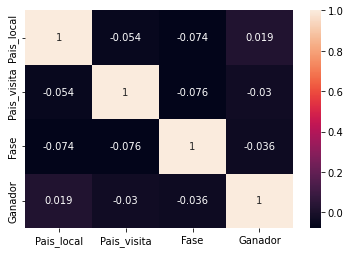

In [61]:
corr_df = df_regresion.corr(method='pearson')

sns.heatmap(corr_df, annot=True)
plt.show()

No se puede hacer una predicción ya que los datos no tienen la correlación suficiente, esto es lógico ya que los datos son muy "basicos" para hacer una predicción, para hacer predicciones se pueden utilizar apis, pero estas son de pago